<a href="https://colab.research.google.com/github/DeepkMenon/Pest-Dataset/blob/main/(1)Detectron2_MaskRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-1xmgz5p1
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-1xmgz5p1
     |████████████████████████████████| 596 kB 35.7 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5-py3-none-any.whl size=65172 sha256=69b082282b141f77d33622f43901c45d2450f1028e2edd5ece7a127f4734af28
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ako4i8n/wheels/24/1d/09/8167de727fe5b74f832b6fcb5d9069d8f03ca29f337bfe484d
Successfully built fvcore
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


'1.11.0+cu113'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo



Cloning into 'detectron2_repo'...
remote: Enumerating objects: 14054, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 14054 (delta 1), reused 9 (delta 1), pack-reused 14044
Receiving objects: 100% (14054/14054), 5.77 MiB | 5.61 MiB/s, done.
Resolving deltas: 100% (10161/10161), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 74 kB 3.6 MB/s 
     |████████████████████████████████| 147 kB 6.8 MB/s 
     |████████████████████████████████| 130 kB 65.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 749 kB 63.5 MB/s 
     |████████████████████████████████| 843 kB 25.1 MB/s 
     |████████████████████████████████| 112 kB 75.3 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=f885a61daa46f4c3ba5138b0cc276ac193a616610e597c2a34a134e1db371383
  Stored in directory: /


# Install detectron2

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use the pest dataset that has been annotated
which has three classes: pieris brasicae caterpillar, mealy bug and fruit sucking moth.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have any of these three categories. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [2]:
!wget https://github.com/DeepkMenon/Pest-Dataset/raw/main/dataset.zip
!unzip /content/dataset.zip

--2022-05-09 09:37:12--  https://github.com/DeepkMenon/Pest-Dataset/raw/main/dataset.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DeepkMenon/Pest-Dataset/main/dataset.zip [following]
--2022-05-09 09:37:14--  https://raw.githubusercontent.com/DeepkMenon/Pest-Dataset/main/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9591033 (9.1M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   9.15M  --.-KB/s    in 0.03s   

2022-05-09 09:37:15 (275 MB/s) - ‘dataset.zip’ saved [9591033/9591033]

Archive:  /content/dataset.zip
   creating: pest

Register the above dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.

In [ ]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

In [3]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("pest_train", {}, "/content/pest/train/via_region_data.json", "/content/pest/train")

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("pest_val", {}, "/content/pest/val/via_region_data.json", "/content/pest/val")

In [5]:
pest_train_metadata = MetadataCatalog.get("pest_train")
dataset_dicts = DatasetCatalog.get("pest_train")

WARNING [05/09 09:50:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/09 09:50:24 d2.data.datasets.coco]: Loaded 183 images in COCO format from /content/pest/train/via_region_data.json


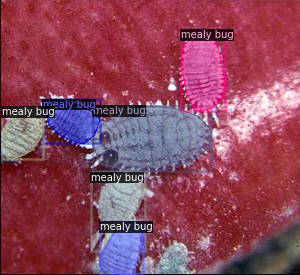

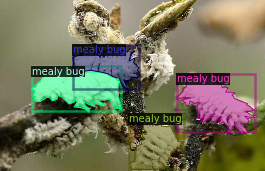

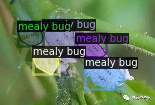

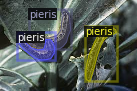

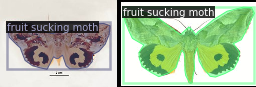

In [11]:
import random

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pest_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.

In [12]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("pest_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 400    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # has three classes. (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/09 09:54:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:11, 15.2MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

[05/09 09:54:59 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/09 09:55:09 d2.utils.events]:  eta: 0:03:01  iter: 19  total_loss: 2.711  loss_cls: 1.33  loss_box_reg: 0.6066  loss_mask: 0.6913  loss_rpn_cls: 0.01282  loss_rpn_loc: 0.01747  time: 0.4656  data_time: 0.0194  lr: 1.2113e-05  max_mem: 2763M
[05/09 09:55:19 d2.utils.events]:  eta: 0:02:52  iter: 39  total_loss: 2.346  loss_cls: 1.087  loss_box_reg: 0.5529  loss_mask: 0.6877  loss_rpn_cls: 0.01445  loss_rpn_loc: 0.02143  time: 0.4710  data_time: 0.0107  lr: 2.4601e-05  max_mem: 2763M
[05/09 09:55:28 d2.utils.events]:  eta: 0:02:42  iter: 59  total_loss: 2.069  loss_cls: 0.7812  loss_box_reg: 0.5325  loss_mask: 0.6758  loss_rpn_cls: 0.01643  loss_rpn_loc: 0.01554  time: 0.4697  data_time: 0.0092  lr: 3.7088e-05  max_mem: 2763M
[05/09 09:55:38 d2.utils.events]:  eta: 0:02:33  iter: 79  total_loss: 1.915  loss_cls: 0.5341  loss_box_reg: 0.576  loss_mask: 0.6537  loss_rpn_cls: 0.007987  loss_rpn_loc: 0.02111  time: 0.4759  data_time: 0.0099  lr: 4.9576e-05  max_mem: 2763M
[05/09 09:55:47

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:

In [13]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/09 10:01:13 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [45]:
pest_val_metadata = MetadataCatalog.get("pest_val")
dataset_dicts = DatasetCatalog.get("pest_val")

WARNING [05/09 10:26:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/09 10:26:07 d2.data.datasets.coco]: Loaded 78 images in COCO format from /content/pest/val/via_region_data.json


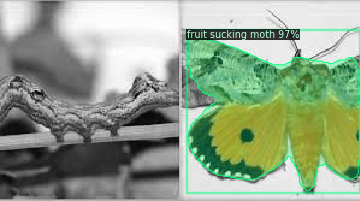

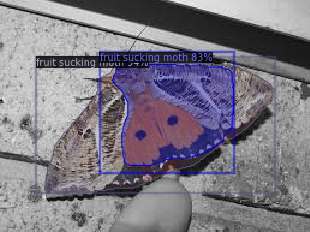

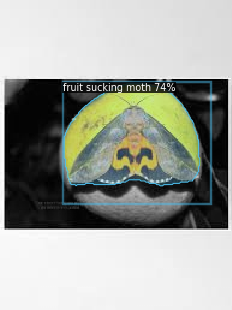

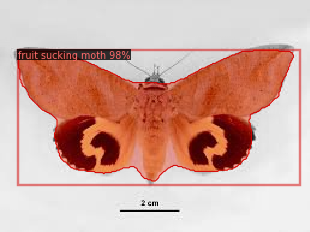

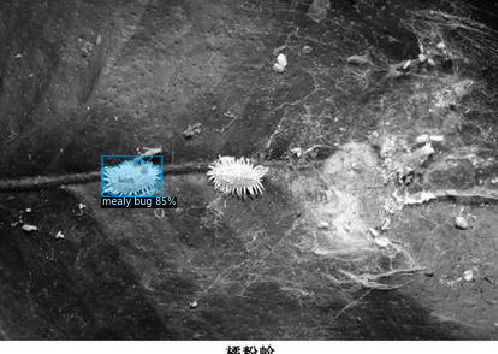

In [49]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=pest_val_metadata, 
                   scale=1.2, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [50]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.12,fps:8.08


## Visualization and curve drawing of detectron2 various losses 

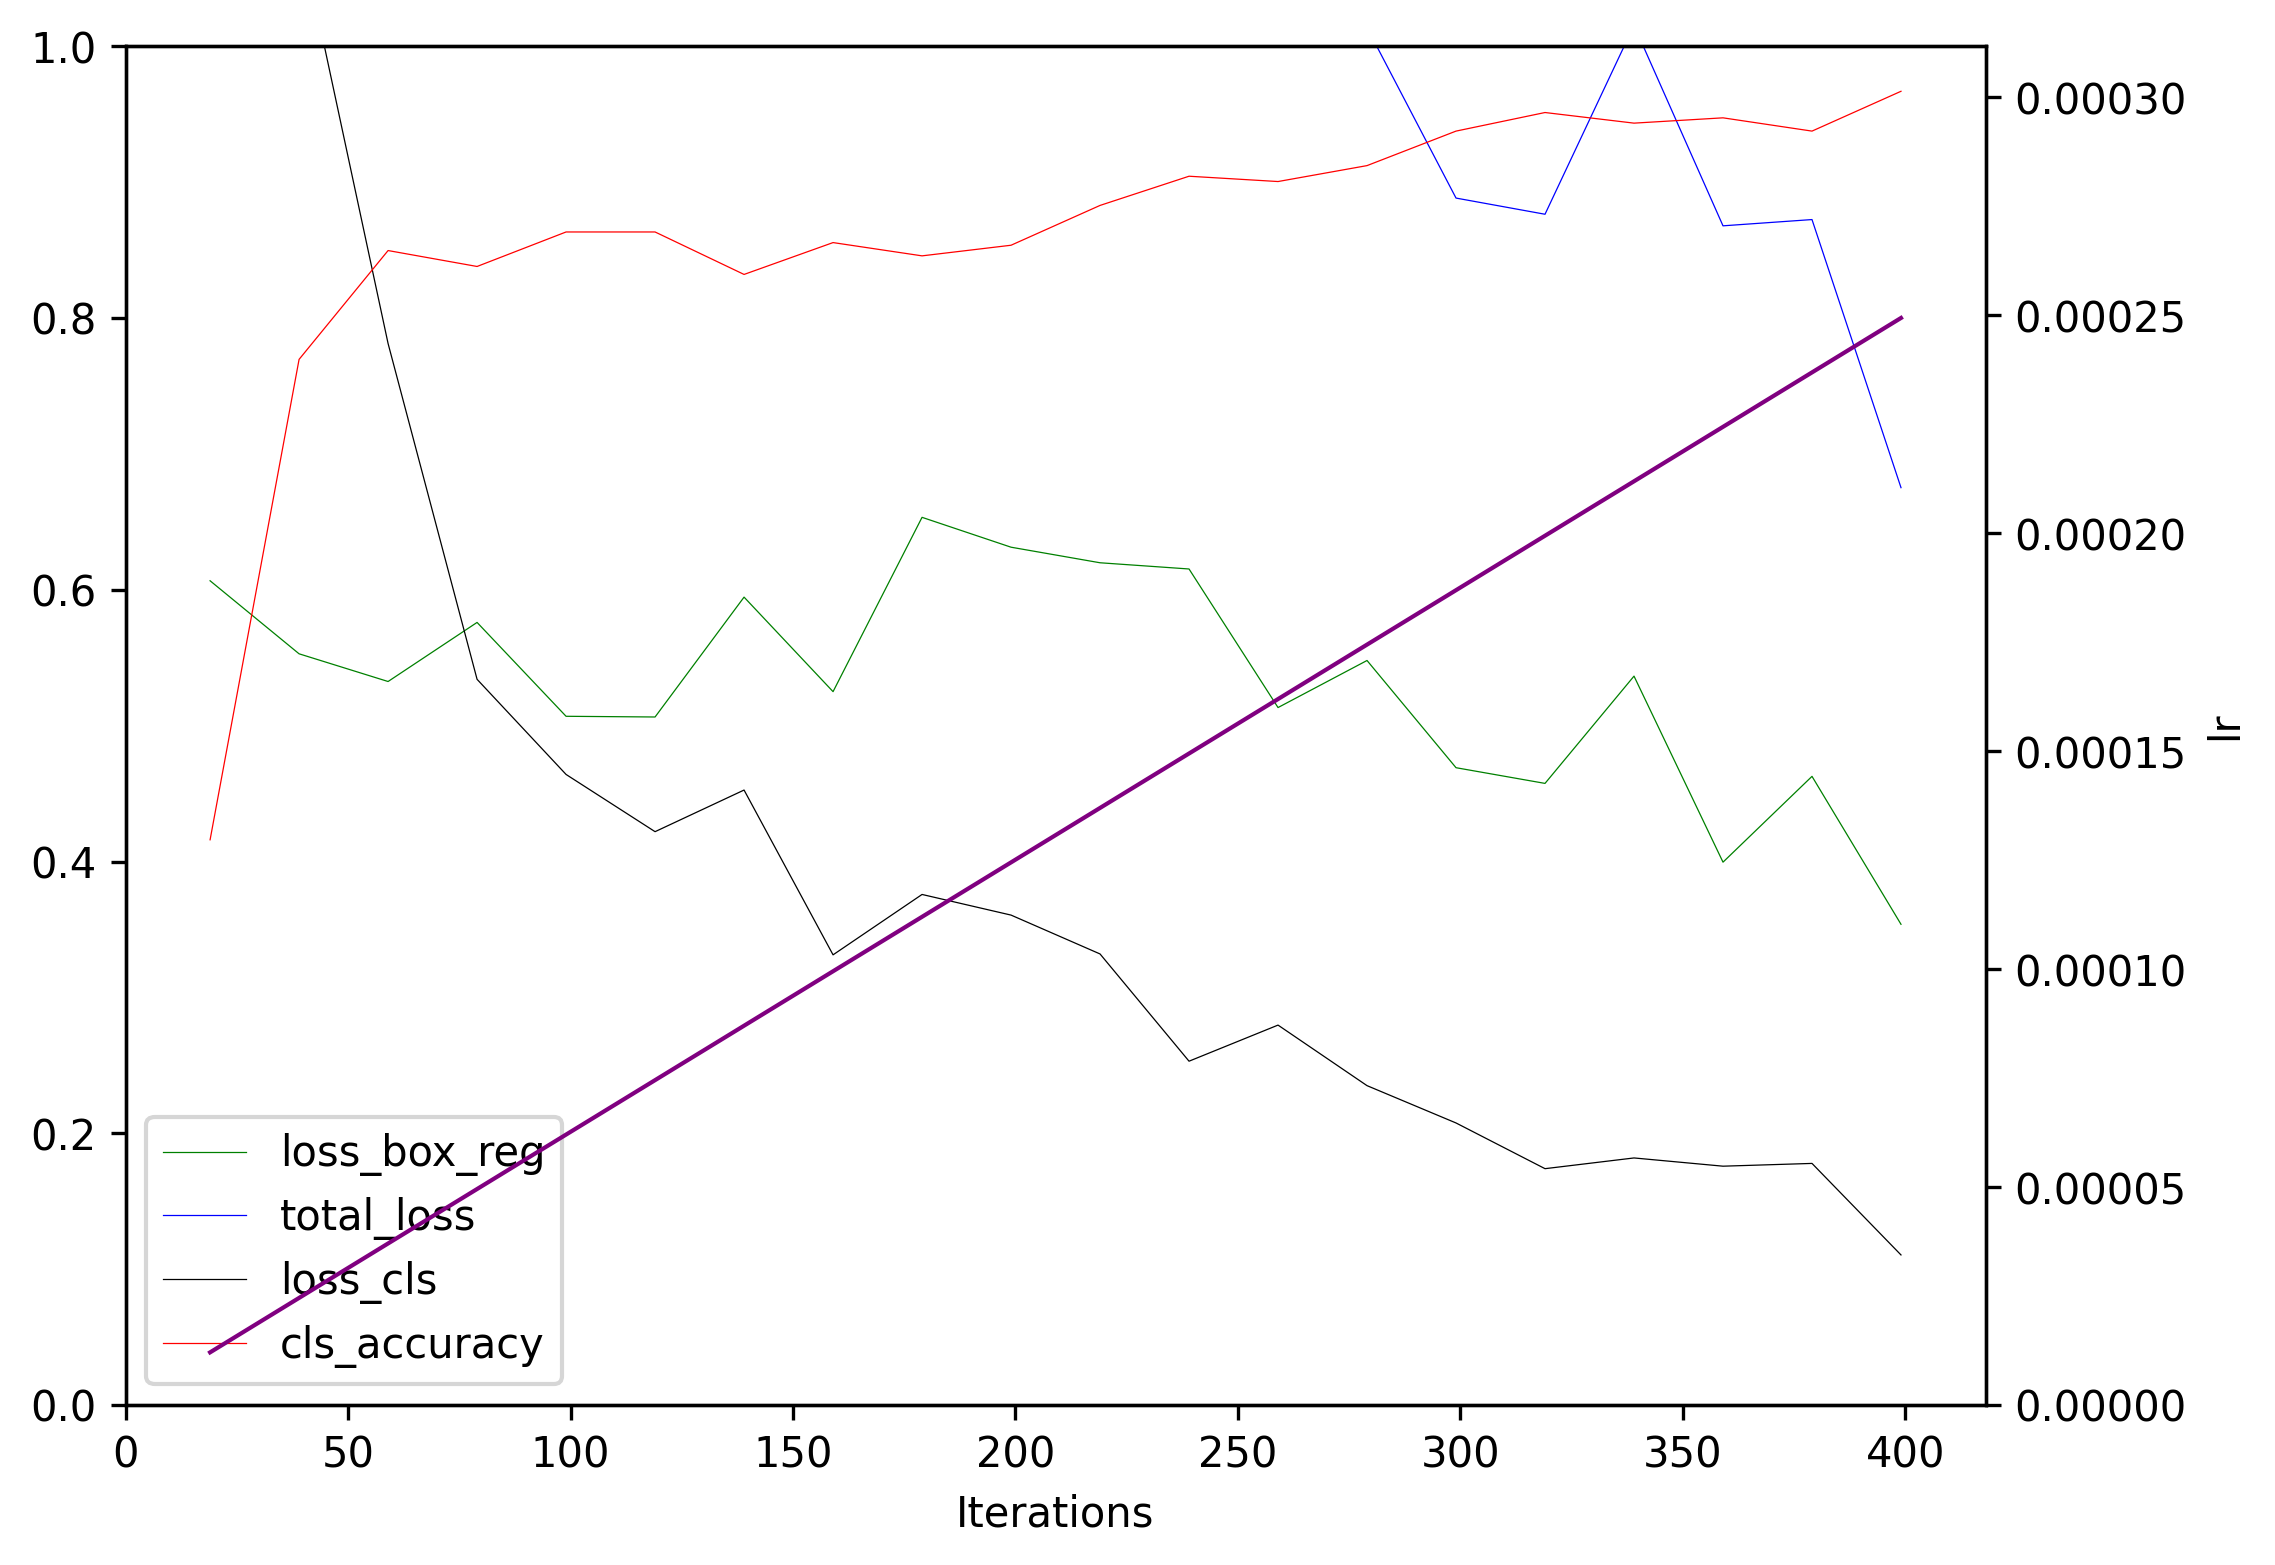

In [51]:
import json
import re
from pylab import *
fig = figure(figsize=(8,6), dpi=300)
y1 = fig.add_subplot(111)
y1.set_xlabel('Iterations')
y2 = y1.twinx()
y1.set_ylim(0,1.0)
parsed=[]
with open('/content/output/metrics.json') as f:
    # whole = f.read()
    # # #pattern = re.compile(r'json_stats: (\{.*\})')
    # pattern = re.compile(r'\"data_time\":.*')
    # # #r:ban zhaunyi
    # lis = pattern.findall(whole)
    try:
        #ke neng chu xian de yi chang kuai
        # parsed = [json.loads(j) for j in lis]
        for line in f:
            parsed.append(json.loads(line))
        # print(parsed[0])

    except:
        #shang shu yi chang kuai de chu li fang fa
        print("json format is not corrrect")
        exit(1)

    _iter = [j['iteration'] for j in parsed]
    _loss = [j['total_loss'] for j in parsed]
    _loss_bbox = [j['loss_box_reg'] for j in parsed]
    _loss_cls = [j['loss_cls'] for j in parsed]
    try:
         _accuracy_cls = [j['fast_rcnn/cls_accuracy'] for j in parsed]
    except:
        _accuracy_cls = None
    _lr = [j['lr'] for j in parsed]
    try:
        _mask_loss = [j['mask_loss'] for j in parsed]
    except:
        _mask_loss = None

    y1.plot(_iter, _loss_bbox, color="green", linewidth=0.3,linestyle="-",label='loss_box_reg')

    y1.plot(_iter, _loss, color="blue", linewidth=0.3, linestyle="-",label='total_loss')
    y1.plot(_iter, _loss_cls, color="black", linewidth=0.3, linestyle="-",label='loss_cls')
    y1.plot(_iter, _accuracy_cls, color="red", linewidth=0.3, linestyle="-",label='cls_accuracy')
    if _mask_loss is not None:
         y1.plot(_iter, _mask_loss, color="grey", linewidth=0.3, linestyle="-",label='mask_loss')

    y2.set_ylim(0,max(_lr)/0.8)
    y2.plot(_iter, _lr, color="purple", linewidth=1.0, linestyle="-",label='lr')
    y2.set_ylabel('lr')

    #可以选择开启网格
    #grid()
    #图例
    y1.legend()
    savefig('./fig.png')
    show()